# Volcanic Ensemble SDE Simulation - Figure 7

This notebook generates the final figure showing the impact of volcanic forcing on AMOC transitions in a simple stochastic differential equation (SDE) model. The analysis includes:

1. **Age Test**: Three ensembles at different interstadial ages (t=12.2, 16.2, 18.2) with constant noise (σ=0.15)
2. **Noise Level Test**: Three ensembles at the same interstadial age (t=18.2) with varying noise levels (σ=0.0, 0.07, 0.10)

Each test includes 50 ensemble members comparing volcanic vs. non-volcanic scenarios.


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy.integrate import odeint

# widgets stuff
import ipywidgets as widgets
from ipywidgets import interact,interactive
from ipywidgets import Checkbox
from scipy.signal import argrelextrema
from matplotlib.animation import FuncAnimation
import os
import sdeint
import seaborn as sns 
from matplotlib import gridspec
from matplotlib.patches import Rectangle

import xarray as xr
import pandas as pd

from numba import jit
from xclim import ensembles

In [2]:
def setaxesfsize(axl, fontsize):
    """Set font size for axis tick labels"""
    for label in axl.get_xticklabels():
        label.set_fontsize(fontsize)
    for label in axl.get_yticklabels():
        label.set_fontsize(fontsize)


In [3]:
# Model parameters
# This cell defines the parameters for the simple AMOC-AABW box model
# The model represents the Atlantic Meridional Overturning Circulation (AMOC)
# and Antarctic Bottom Water (AABW) as a coupled system of stochastic differential equations

b0 = 0.625
q0 = -9.
q1 = 12.
tau = 0.902
tc = 166.66  # Characteristic time constant
Bbar = 3.4164 
eta = 0.5
gammabar = 1.22

def B0(gamma):
    """Calculate B0 based on gamma"""
    return Bbar + eta * (gammabar - gamma)

def dA(A, B, gamma, sigma, dt):
    """Stochastic differential equation for AMOC (A)"""
    drift = -(B - B0(gamma)) - np.abs(q0 + q1*(A - b0))*(A - b0)
    diffusion = sigma * np.random.normal()
    return drift * dt + diffusion * np.sqrt(dt)

def dB(A, gamma, sigma, dt):
    """Stochastic differential equation for AABW (B)"""
    drift = (A - gamma) / tau
    diffusion = sigma * np.random.normal()
    return drift * dt + diffusion * np.sqrt(dt)

def get_ensmem(sigma, gamma, volc=False, volct=15.0, volcdt=0.1, volcamp=0.005, 
               tlen=40.01, dt=0.001, t0=0, aabw0=1.0, amoc0=1.0, pert=0.0, vduration=0.07):
    """Generate a single ensemble member simulation"""
    simtime = np.arange(t0, tlen, dt)
    AMOC_nd = np.zeros(len(simtime))
    AABW_nd = np.zeros(len(simtime))
    
    # Set initial conditions with optional perturbation
    AABW_nd[0] = aabw0 + pert * (0.5 - np.random.rand())
    AMOC_nd[0] = amoc0 + pert * (0.5 - np.random.rand())
    
    # Set up volcanic forcing
    vtime = np.linspace(0, vduration, int(0.1/dt))
    freq = 1000 * np.pi
    volcseries = volcamp * np.cos(freq * vtime * np.pi / 180.)
    
    # Main integration loop
    j = 0
    for i, t in enumerate(simtime[:-1]):
        if volc and volct <= t < volct + volcdt:
            # Apply volcanic forcing
            AMOC_nd[i+1] = AMOC_nd[i] + dA(AMOC_nd[i], AABW_nd[i], gamma, sigma, dt) + volcseries[j]
            AABW_nd[i+1] = AABW_nd[i] + dB(AMOC_nd[i], gamma, sigma, dt)
            j += 1
        else:
            # Normal evolution without volcanic forcing
            AMOC_nd[i+1] = AMOC_nd[i] + dA(AMOC_nd[i], AABW_nd[i], gamma, sigma, dt)
            AABW_nd[i+1] = AABW_nd[i] + dB(AMOC_nd[i], gamma, sigma, dt)
    
    return simtime, AMOC_nd, AABW_nd

Generating control run...


Text(0, 0.5, 'Normalized AMOC Strength')

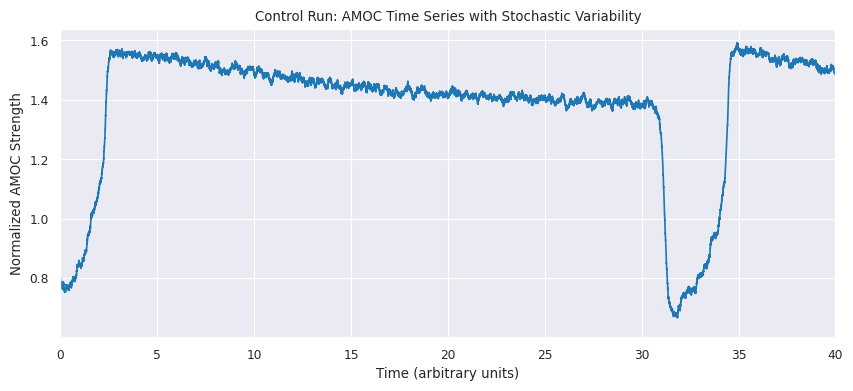

In [87]:
# Generate control run with noise to show realistic D-O oscillations
# This creates a baseline simulation showing natural variability in the AMOC
# The control run will be used as the background for all ensemble tests
# Initial conditions are set to produce Dansgaard-Oeschger (D-O) type transitions

print("Generating control run...")

gamma = 1.385

novolcsim = get_ensmem(sigma=0.05, gamma=gamma, volc=False, tlen=200, dt=0.001, aabw0=2.5, amoc0=0.8, pert=0.0)

# Create xarray Dataset for control run
xr_novolcsim = xr.Dataset(
    {
        "AMOC": (("time"), novolcsim[1]),
        "AABW": (("time"), novolcsim[2])
    },
    coords={"time": novolcsim[0]}
)

# we want the first random transitions to occur around t = 27 to 30
# to make things agree with the complex model
# just rerun until it is approximately there

fig, ax = plt.subplots(figsize=(10,4))
xr_novolcsim.AMOC.plot(ax=ax)
plt.xlim(0,40)
plt.title("Control Run: AMOC Time Series with Stochastic Variability")
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Normalized AMOC Strength")


In [88]:
# Generate Age Test Ensembles (sigma = 0.15)
# This cell creates three ensembles at different interstadial ages to test
# how the timing of volcanic forcing affects AMOC transitions
# Each ensemble has 50 members: one with volcanic forcing, one without
# Volcanic amplitude: 0.006, Noise level: σ=0.15 (constant for all three)
# Times tested: t=10.2, t=16.2, and t=26.2 (model time units)

print("Generating age test ensembles...")
nruns = 50
sig = 0.15
gamma = 1.385
#vamp = 0.005
vamp = 0.006
vduration = 0.07
ipert = 1.e-2

# Ensemble 1: Initial time at t=10.0
it1 = 10000
volc_init1 = 10.2
tdur = 40
x5novolc_t = xr_novolcsim.AMOC.time[it1]
x5novolc_amoc = xr_novolcsim.AMOC[it1]
x5novolc_aabw = xr_novolcsim.AABW[it1]

ens_novolc_sim_1 = [get_ensmem(sig, gamma, volc=False, volct=volc_init1, volcdt=0.1, volcamp=vamp, 
                                tlen=tdur, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                                amoc0=x5novolc_amoc, pert=ipert, vduration=vduration) 
                    for i in range(nruns)]
ens_volc_sim_1 = [get_ensmem(sig, gamma, volc=True, volct=volc_init1, volcdt=0.1, volcamp=vamp, 
                              tlen=tdur, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                              amoc0=x5novolc_amoc, pert=ipert, vduration=vduration) 
                  for i in range(nruns)]

# Ensemble 2: Initial time at t=16.0
it2 = 16000
volc_init2 = 16.2
tdur = 42
x5novolc_t = xr_novolcsim.AMOC.time[it2]
x5novolc_amoc = xr_novolcsim.AMOC[it2]
x5novolc_aabw = xr_novolcsim.AABW[it2]

ens_novolc_sim_2 = [get_ensmem(sig, gamma, volc=False, volct=volc_init2, volcdt=0.1, volcamp=vamp, 
                                tlen=tdur, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                                amoc0=x5novolc_amoc, pert=ipert, vduration=vduration) 
                    for i in range(nruns)]
ens_volc_sim_2 = [get_ensmem(sig, gamma, volc=True, volct=volc_init2, volcdt=0.1, volcamp=vamp, 
                              tlen=tdur, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                              amoc0=x5novolc_amoc, pert=ipert, vduration=vduration) 
                  for i in range(nruns)]

# Ensemble 3: Initial time at t=22.0
#it3 = 18000
it3 = 22000
volc_init3 = 22.2
tdur = 42
x5novolc_t = xr_novolcsim.AMOC.time[it3]
x5novolc_amoc = xr_novolcsim.AMOC[it3]
x5novolc_aabw = xr_novolcsim.AABW[it3]

ens_novolc_sim_3 = [get_ensmem(sig, gamma, volc=False, volct=volc_init3, volcdt=0.1, volcamp=vamp, 
                                tlen=tdur, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                                amoc0=x5novolc_amoc, pert=ipert, vduration=vduration) 
                    for i in range(nruns)]
ens_volc_sim_3 = [get_ensmem(sig, gamma, volc=True, volct=volc_init3, volcdt=0.1, volcamp=vamp, 
                              tlen=tdur, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                              amoc0=x5novolc_amoc, pert=ipert, vduration=vduration) 
                  for i in range(nruns)]

print("Age test ensembles complete.")

Generating age test ensembles...
Age test ensembles complete.
Age test ensembles complete.


In [89]:
def create_ensemble_xarray(ensemble_data_list):
    """
    Create xarray Dataset for ensemble simulation data.
    
    Parameters:
    ensemble_data_list: List of simulation outputs, each containing (time, AMOC, AABW)
    
    Returns:
    xr.Dataset with dimensions for ensemble members and time
    """
    time = ensemble_data_list[0][0]
    num_members = len(ensemble_data_list)
    
    # Extract AMOC data for all ensemble members
    ensemble_data = np.array([ensemble_data_list[i][1] for i in range(num_members)])
    
    return xr.Dataset(
        {"AMOC": (("realization", "time"), ensemble_data)},
        coords={"realization": np.arange(num_members), "time": time}
    )

# Create xarray datasets for age test ensembles
xr_ens_novolc_1 = create_ensemble_xarray(ens_novolc_sim_1)
xr_ens_novolc_1_mean = xr_ens_novolc_1.mean(dim="realization")
xr_ens_volc_1 = create_ensemble_xarray(ens_volc_sim_1)
xr_ens_volc_1_mean = xr_ens_volc_1.mean(dim="realization")

xr_ens_novolc_2 = create_ensemble_xarray(ens_novolc_sim_2)
xr_ens_novolc_2_mean = xr_ens_novolc_2.mean(dim="realization")
xr_ens_volc_2 = create_ensemble_xarray(ens_volc_sim_2)
xr_ens_volc_2_mean = xr_ens_volc_2.mean(dim="realization")

xr_ens_novolc_3 = create_ensemble_xarray(ens_novolc_sim_3)
xr_ens_novolc_3_mean = xr_ens_novolc_3.mean(dim="realization")
xr_ens_volc_3 = create_ensemble_xarray(ens_volc_sim_3)
xr_ens_volc_3_mean = xr_ens_volc_3.mean(dim="realization")


In [90]:
# Generate Noise Level Test Ensembles (all at t=16.2 with different sigma)
# This cell creates three ensembles at the same interstadial age (t=16.2) but with
# different noise levels to test how background variability affects volcanic sensitivity
# Each ensemble has 50 members: one with volcanic forcing, one without
# Volcanic amplitude: 0.006 (same as age test), Time: t=16.2 (fixed)
# Noise levels tested: σ=0.0 (no noise), σ=0.07 (moderate), σ=0.15 (high)

print("Generating noise level test ensembles...")
nruns = 50
gamma = 1.385
# use same volcanic amplitude as age test ensembles
#vamp = 0.0048
#vamp = 0.007
ipert = 1.e-2

# Use initial condition at t=16.0 for noise level test
itn = 16000
volc_initn = 16.2
x5novolc_t = xr_novolcsim.AMOC.time[itn]
x5novolc_amoc = xr_novolcsim.AMOC[itn]
x5novolc_aabw = xr_novolcsim.AABW[itn]

# Noise level 1: sigma = 0.0
sig = 0.0
ens_novolc_sim_1n = [get_ensmem(sig, gamma, volc=False, volct=volc_initn, volcdt=0.1, volcamp=vamp, 
                                 tlen=40, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                                 amoc0=x5novolc_amoc, pert=ipert) for i in range(nruns)]
ens_volc_sim_1n = [get_ensmem(sig, gamma, volc=True, volct=volc_initn, volcdt=0.1, volcamp=vamp, 
                               tlen=40, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                               amoc0=x5novolc_amoc, pert=ipert) for i in range(nruns)]

# Noise level 2: sigma = 0.03
#sig = 0.03
sig = 0.07
ens_novolc_sim_2n = [get_ensmem(sig, gamma, volc=False, volct=volc_initn, volcdt=0.1, volcamp=vamp, 
                                 tlen=40, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                                 amoc0=x5novolc_amoc, pert=ipert) for i in range(nruns)]
ens_volc_sim_2n = [get_ensmem(sig, gamma, volc=True, volct=volc_initn, volcdt=0.1, volcamp=vamp, 
                               tlen=40, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                               amoc0=x5novolc_amoc, pert=ipert) for i in range(nruns)]

# Noise level 3: sigma = 0.07
#sig = 0.07
sig = 0.15
ens_novolc_sim_3n = [get_ensmem(sig, gamma, volc=False, volct=volc_initn, volcdt=0.1, volcamp=vamp, 
                                 tlen=40, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                                 amoc0=x5novolc_amoc, pert=ipert) for i in range(nruns)]

ens_volc_sim_3n = [get_ensmem(sig, gamma, volc=True, volct=volc_initn, volcdt=0.1, volcamp=vamp, 
                               tlen=40, dt=0.001, t0=x5novolc_t, aabw0=x5novolc_aabw, 
                               amoc0=x5novolc_amoc, pert=ipert) for i in range(nruns)]

print("Noise level test ensembles complete.")

Generating noise level test ensembles...
Noise level test ensembles complete.
Noise level test ensembles complete.


In [91]:
# Create xarray datasets for noise level test ensembles
xr_ens_novolc_1n = create_ensemble_xarray(ens_novolc_sim_1n)
xr_ens_novolc_1n_mean = xr_ens_novolc_1n.mean(dim="realization")
xr_ens_volc_1n = create_ensemble_xarray(ens_volc_sim_1n)
xr_ens_volc_1n_mean = xr_ens_volc_1n.mean(dim="realization")

xr_ens_novolc_2n = create_ensemble_xarray(ens_novolc_sim_2n)
xr_ens_novolc_2n_mean = xr_ens_novolc_2n.mean(dim="realization")
xr_ens_volc_2n = create_ensemble_xarray(ens_volc_sim_2n)
xr_ens_volc_2n_mean = xr_ens_volc_2n.mean(dim="realization")

xr_ens_novolc_3n = create_ensemble_xarray(ens_novolc_sim_3n)
xr_ens_novolc_3n_mean = xr_ens_novolc_3n.mean(dim="realization")
xr_ens_volc_3n = create_ensemble_xarray(ens_volc_sim_3n)
xr_ens_volc_3n_mean = xr_ens_volc_3n.mean(dim="realization")


In [92]:
### Note the model is very sensitive the control D-O cycle (i.e. whether we get a tipping event half way throught the cycle)
#### This is necessary to get the right behavior as observed in Figure 7 from the paper.
#### Noise plays a significant role in reproducing the results

In [93]:
# Plotting Functions
# This cell defines helper functions for creating the final multi-panel figure:
# - add_rectangle: Draws zoom region boxes on the overview plots
# - calc_tprob: Calculates transition probability (% of ensemble members transitioning)
# - plot_zoom: Creates detailed zoom plots with ensemble members, means, and histograms
#
# The plot_zoom function handles:
#   * Plotting all 50 ensemble members (volcanic vs. non-volcanic)
#   * Adding ensemble means and basin boundary markers
#   * Creating histogram insets showing final AMOC distribution
#   * Calculating and displaying transition probabilities

def add_rectangle(ax, x_start, x_end, y_start, y_end, color, border_color="black", border_width=0.7):
    """Add a rectangle to the given axis"""
    rect_width = x_end - x_start
    rect_height = y_end - y_start
    rect = Rectangle((x_start, y_start), width=rect_width, height=rect_height, color=color)
    border = Rectangle((x_start, y_start), width=rect_width, height=rect_height,
                       facecolor="none", edgecolor=border_color, linewidth=border_width)
    ax.add_patch(rect)
    ax.add_patch(border)

def calc_tprob(data, threshold_val):
    """Calculate transition probability below threshold"""
    data_series = pd.Series(data)
    count_below = data_series[data_series < threshold_val].count()
    return 100.0 * count_below / 50  # 50 ensemble members

def plot_zoom(axtop, axzoom, axins, xr_ens_novolc, xr_ens_volc, xr_ens_novolc_mean, xr_ens_volc_mean,
              eq_v, xzoom_start, xzoom_end, endtime, threshold_val, nruns, labelx=True, labely=True):
    """Plot zoomed ensemble with histogram inset"""
    sns.set_style("darkgrid")
    
    # Plot parameters
    esalp = 0.6  # ensemble line transparency
    esmalp = 0.9  # ensemble mean line transparency
    eslw = 0.5  # ensemble line width
    esmlw = 2.0  # ensemble mean line width
    axzoomfs = 12
    axinsfs = 12
    axlbls = 14
    ymin, ymax = 0.4, 1.8
    
    # Plot control run
    xr_novolcsim.AMOC.plot(ax=axzoom, color="blue", linewidth=1.0, alpha=0.7)
    
    # Plot ensemble members with smoothing
    window = 6
    # Plot first member of each ensemble with label, rest without
    xr_ens_novolc.AMOC[0].rolling(time=window, center=True).mean().plot(
        ax=axzoom, color="blue", linewidth=eslw, alpha=esalp, label="Noise Ensemble")
    [xr_ens_novolc.AMOC[i].rolling(time=window, center=True).mean().plot(
        ax=axzoom, color="blue", linewidth=eslw, alpha=esalp) for i in range(1, nruns)]
    
    xr_ens_volc.AMOC[0].rolling(time=window, center=True).mean().plot(
        ax=axzoom, color="red", linewidth=eslw, alpha=esalp, label="Volcanic Ensemble")
    [xr_ens_volc.AMOC[i].rolling(time=window, center=True).mean().plot(
        ax=axzoom, color="red", linewidth=eslw, alpha=esalp) for i in range(1, nruns)]
    
    # Plot ensemble means
    #xr_ens_novolc_mean.AMOC.plot(ax=axzoom, color="cyan", linewidth=esmlw, alpha=esmalp, label="Noise (Ens Mean)")
    #xr_ens_volc_mean.AMOC.plot(ax=axzoom, color="yellow", linewidth=esmlw, alpha=esmalp, label="Volc (Ens Mean)")
    
    # Add basin boundary as transparent green shaded region
    axzoom.axhspan(ymin=1.198, ymax=1.302, color='green', alpha=0.15, zorder=0, label='Basin Boundary')
    
    # Format zoom plot - set limits AFTER all plotting and turn off autoscale
    axzoom.autoscale(False)
    axzoom.set_xlim(xzoom_start, xzoom_end)
    axzoom.set_ylim(ymin, ymax)
    axzoom.vlines(eq_v, ymin, ymax, color="red", alpha=0.7, linewidths=2.0, zorder=1)
    setaxesfsize(axzoom, axzoomfs)
    axzoom.set_xlabel("Model Time (non-dim)" if labelx else "", size=axlbls)
    axzoom.set_ylabel("AMOC Max (non-dim)" if labely else "", size=axlbls)
    axzoom.grid()
    axzoom.legend(loc=3, fontsize=10, facecolor='#ffffff', framealpha=1.0)
    axzoom.set_title("")
    
    # Add volcanic event annotation
    vlabxy = (0.254, 0.54)
    vlabxyt = (0.02, 0.54)
    axzoom.annotate('Volcanic\nEvent', xy=vlabxy, xycoords='axes fraction', xytext=vlabxyt,
                    textcoords='axes fraction', arrowprops=dict(facecolor='red', shrink=0.05),
                    horizontalalignment='left', verticalalignment='top', size=12,
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor='#ffffff', alpha=1.0))
    
    # Clean up tick labels
    xticks = axzoom.get_xticks()
    labels = [item.get_text() for item in axzoom.get_xticklabels()]
    if len(labels) > 1:
        labels[-1] = ""
    axzoom.set_xticks(xticks)
    axzoom.set_xticklabels(labels)
    axzoom.tick_params(bottom=False, right=False)
    axtop.set_title("")
    
    # Inset histogram
    axins.set_xlim(0, 20)
    
    xr_ens_novolc_lastyr = xr_ens_novolc.AMOC.isel(time=endtime)
    xr_ens_volc_lastyr = xr_ens_volc.AMOC.isel(time=endtime)
    
    sns.histplot(ax=axins, y=xr_ens_novolc_lastyr, kde=True, orientation="vertical",
                 binwidth=0.03, binrange=[ymin, ymax], color="blue", alpha=0.3, label="NoVolc")
    sns.histplot(ax=axins, y=xr_ens_volc_lastyr, kde=True, orientation="vertical",
                 binwidth=0.03, binrange=[ymin, ymax], color="red", alpha=0.3, label="Volc")
    
    # Format inset - set ylim AFTER plotting and turn off autoscale
    axins.autoscale(False)
    axins.set_ylim(ymin, ymax)
    axins.tick_params(axis="x", direction="in", pad=-15)
    axins.set_ylabel("Final AMOC Max", size=axlbls)
    axins.set_xlabel("Member Count", size=axlbls)
    axins.xaxis.set_label_coords(0.5, -0.04)
    axins.yaxis.set_label_coords(0.7, 0.5)
    axins.yaxis.set_label_position("right")
    axins.yaxis.tick_right()
    axins.tick_params(axis="y", direction="in", pad=-25)
    setaxesfsize(axins, axinsfs)
    axins.grid()
    axins.axhspan(ymin=1.198, ymax=1.302, color='green', alpha=0.15, zorder=0)
    
    # Add probability labels - volcanic on timeseries, noise on histogram
    tprob_volc = calc_tprob(xr_ens_volc_lastyr, threshold_val)
    tprob_novolc = calc_tprob(xr_ens_novolc_lastyr, threshold_val)
    axzoom.text(0.36, 0.94, f'Volcanic Transitions: {tprob_volc:.0f}%', transform=axzoom.transAxes,
               size=axinsfs, color='red', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black",
               facecolor='#ffffff', alpha=1.0), zorder=10)
    axins.text(0.35, 0.94, f'Noise Transitions: {tprob_novolc:.0f}%', transform=axins.transAxes,
               size=axinsfs, color='blue', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black",
               facecolor='#ffffff', alpha=1.0), zorder=10, ha='center')
    
    # Clean up inset tick labels
    xticks = axins.get_xticks()
    labels = [item.get_text() for item in axins.get_xticklabels()]
    if len(labels) > 1:
        labels[0] = labels[-1] = ""
    axins.set_xticks(xticks)
    axins.set_xticklabels(labels)
    
    yticks = axins.get_yticks()
    labels = [item.get_text() for item in axins.get_yticklabels()]
    if len(labels) > 1:
        labels[0] = labels[-1] = ""
    axins.set_yticks(yticks)
    axins.set_yticklabels(labels)

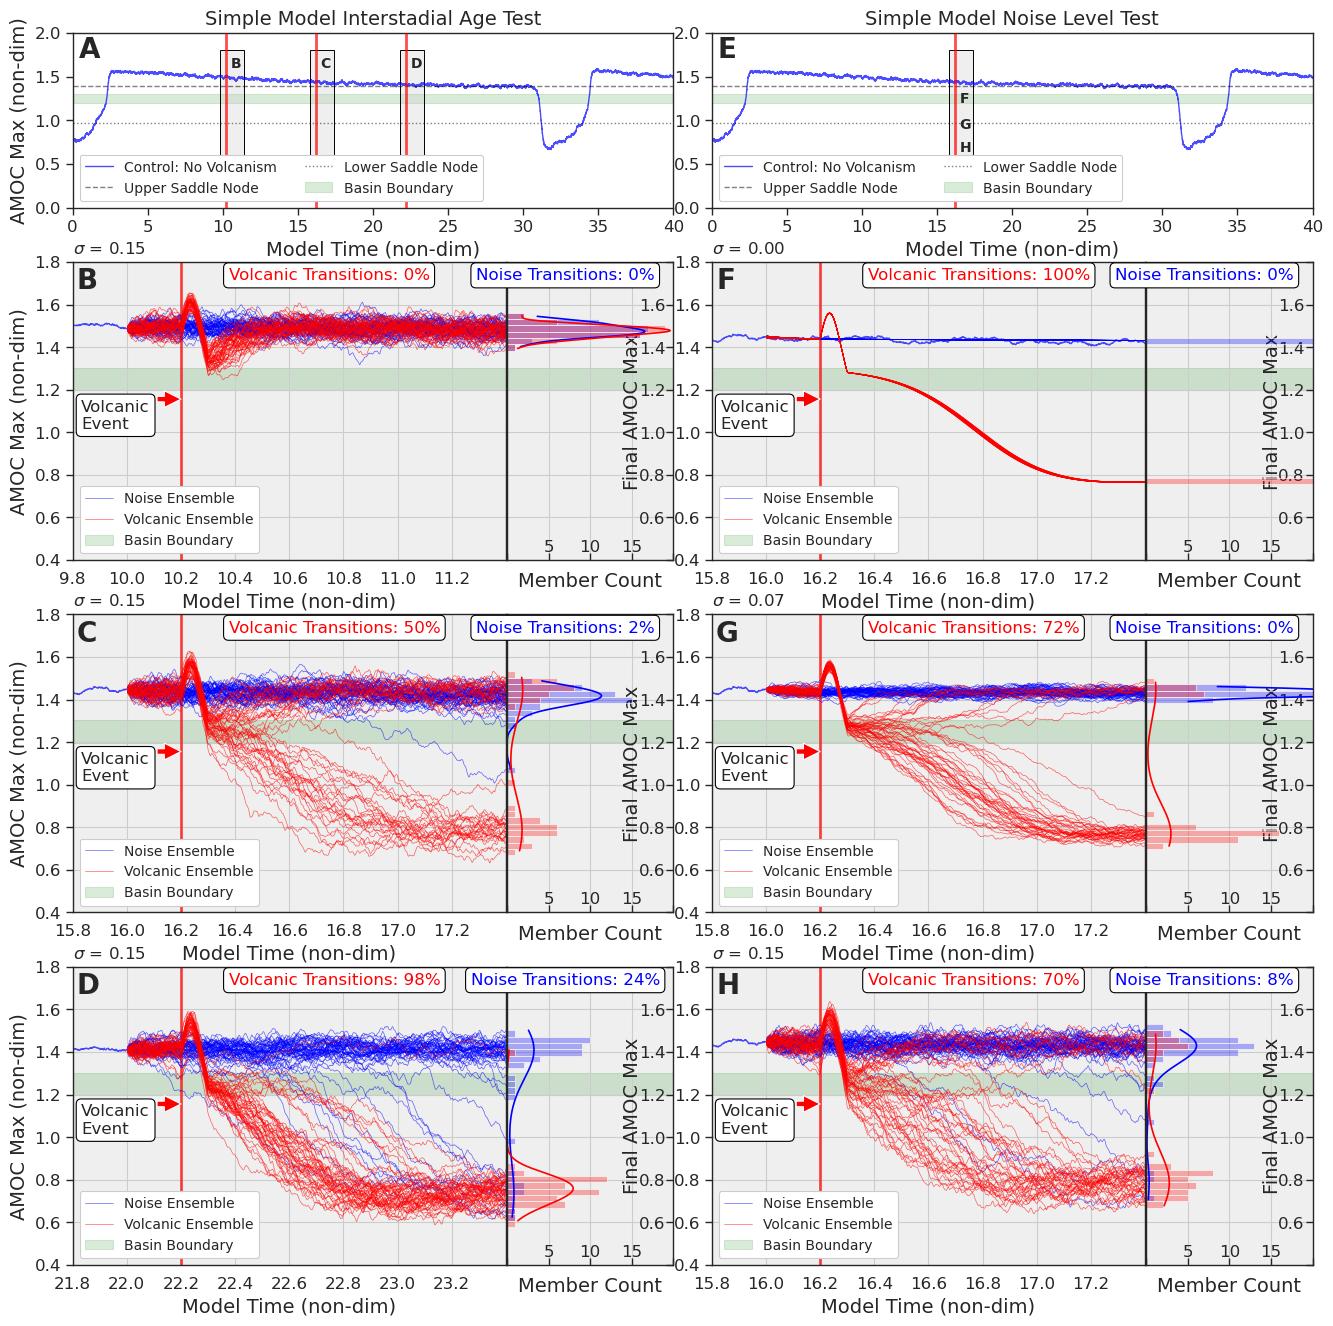

In [94]:
#### Main Figure Generation
# This cell creates the complete multi-panel figure showing:
#
# LEFT SIDE (Age Test):
#   - Panel A: Overview showing control run with three zoom regions
#   - Panels B, C, D: Zoomed views at t=10.2, 16.2, 26.2 with σ=0.15
#
# RIGHT SIDE (Noise Level Test):
#   - Panel E: Overview showing control run with one zoom region (t=16.2)
#   - Panels F, G, H: Zoomed views at t=16.2 with σ=0.0, 0.07, 0.15
#
# Each zoom panel includes:
#   * 50 ensemble members (blue=noise only, red=volcanic)
#   * Ensemble means (cyan=noise, yellow=volcanic)
#   * Histogram showing final AMOC distribution
#   * Transition probabilities for both ensembles
#
# Grey backgrounds on zoom panels match grey boxes in overview plots

fig = plt.figure(figsize=(16, 16))

# set the style
sns.set_style("ticks")
sns.set_context("paper")

# Create a 1x6 grid (this can be adjusted based on your needs)
gs = gridspec.GridSpec(140, 200)

# Three horizontal axes spanning the entire width
zoomcolor = (0.8, 0.8, 0.8, 0.3)  # lightgray with 0.3 transparency, we are going to zoom out this area
tlmid = 97 #vertical center between subplots
trmid = 103
ax0 = fig.add_subplot(gs[0:20, :tlmid])
ax1 = fig.add_subplot(gs[26:60, 0:70], facecolor=zoomcolor)
axins1 = fig.add_subplot(gs[26:60, 70:tlmid], facecolor=zoomcolor)
ax2 = fig.add_subplot(gs[66:100, 0:70], facecolor=zoomcolor)
axins2 = fig.add_subplot(gs[66:100, 70:tlmid], facecolor=zoomcolor)
ax3 = fig.add_subplot(gs[106:140, 0:70], facecolor=zoomcolor)
axins3 = fig.add_subplot(gs[106:140, 70:tlmid], facecolor=zoomcolor)

# Duplicate axes on the right
ax0_dup = fig.add_subplot(gs[0:20, trmid:])
ax1_dup = fig.add_subplot(gs[26:60, trmid:173], facecolor=zoomcolor)
axins1_dup = fig.add_subplot(gs[26:60, 173:200], facecolor=zoomcolor)
ax2_dup = fig.add_subplot(gs[66:100, trmid:173], facecolor=zoomcolor)
axins2_dup = fig.add_subplot(gs[66:100, 173:200], facecolor=zoomcolor)
ax3_dup = fig.add_subplot(gs[106:140, trmid:173], facecolor=zoomcolor)
axins3_dup = fig.add_subplot(gs[106:140, 173:200], facecolor=zoomcolor)

ax = [ax0, ax1, axins1, ax2, axins2, ax3, axins3, ax0_dup, ax1_dup, axins1_dup, ax2_dup, axins2_dup, ax3_dup, axins3_dup]

################## Main Plot
lw = 1.5
lalp = 0.7
ax0ymax = 2.0
ax0ymin = 0.
axlbls = 14  # axes label size
axts = 12  # axes tick label size

################ Define volcanic event times (CHANGE ONLY THESE!)
# These should match the values used in ensemble generation
volc_time_1 = 10.2  # corresponds to it1 = 10000
volc_time_2 = 16.2  # corresponds to it2 = 16000
volc_time_3 = 22.2  # corresponds to it3 = 22000
volc_time_n = 16.2  # corresponds to itn = 16000

################ Define zoom regions (automatically calculated from volcanic times)
zoom_width = 1.6  # Width of zoom window (symmetric around volcanic event)
xzoom1_start = volc_time_1 - 0.4
xzoom1_end = volc_time_1 + 1.2
xzoom2_start = volc_time_2 - 0.4
xzoom2_end = volc_time_2 + 1.2
xzoom3_start = volc_time_3 - 0.4
xzoom3_end = volc_time_3 + 1.2
xzoom3_dup_start = volc_time_n - 0.4
xzoom3_dup_end = volc_time_n + 1.2

# Add vertical lines for volcanic events (automatically from defined times)
vgrid = [volc_time_1, volc_time_2, volc_time_3]
rec_ymin = 0.4
rec_ymax = 1.8
[ax0.vlines(vgrid[i], ax0ymin, ax0ymax, color="red", alpha=0.7, linewidths=2.0, zorder=3)
 for i in [0,1,2]]
add_rectangle(ax0, xzoom1_start, xzoom1_end, rec_ymin, rec_ymax, zoomcolor)
add_rectangle(ax0, xzoom2_start, xzoom2_end, rec_ymin, rec_ymax, zoomcolor)
add_rectangle(ax0, xzoom3_start, xzoom3_end, rec_ymin, rec_ymax, zoomcolor)

vgrid_dup = [volc_time_n]
[ax0_dup.vlines(vgrid_dup[i], ax0ymin, ax0ymax, color="red", alpha=0.7, linewidths=2.0, zorder=3)
 for i in [0]]
add_rectangle(ax0_dup, xzoom3_dup_start, xzoom3_dup_end, rec_ymin, rec_ymax, zoomcolor)

cntcol = "black"
cntalp = 0.5
# volcanic run colors
vcols = ["purple", "blue", "red"]
# eruption colors
ecols = ["magenta", "cyan", "orange"]

# Define threshold value before using it
threshold_val = 1.18
nruns = 50
endtime = 1400  # this is in 0.001 dt units

# Plot control run
xr_novolcsim.AMOC.plot(
    ax=ax0,
    color="blue",
    linewidth=1.0,
    alpha=0.7,
    label="Control: No Volcanism",
    zorder=2
)

ax0.axhline(
    1.388,
    0,
    1,
    color="k",
    alpha=0.5,
    linewidth=1.0,
    linestyle="dashed",
    label="Upper Saddle Node",
)
ax0.axhline(
    0.97,
    0,
    1,
    color="k",
    alpha=0.5,
    linewidth=1.0,
    linestyle="dotted",
    label="Lower Saddle Node",
)
# Add basin boundary as transparent green shaded region
ax0.axhspan(1.198, 1.302, color='green', alpha=0.15, zorder=0, label="Basin Boundary")

# Duplicate the main plot on the right
ax0_dup.plot(xr_novolcsim.time, xr_novolcsim.AMOC, color="blue", linewidth=1.0, alpha=0.7, label="Control: No Volcanism", zorder=2)
ax0_dup.axhline(1.388, 0, 1, color="k", alpha=0.5, linewidth=1.0, linestyle="dashed", label="Upper Saddle Node")
ax0_dup.axhline(0.97, 0, 1, color="k", alpha=0.5, linewidth=1.0, linestyle="dotted", label="Lower Saddle Node")
# Add basin boundary as transparent green shaded region
ax0_dup.axhspan(1.198, 1.302, color='green', alpha=0.15, zorder=0, label="Basin Boundary")

# Create zoom plots (using automatically defined times)
zoomplot_1 = plot_zoom(ax0, ax1, axins1, xr_ens_novolc_1, xr_ens_volc_1, xr_ens_novolc_1_mean, xr_ens_volc_1_mean,
            volc_time_1, xzoom1_start, xzoom1_end, endtime, threshold_val, nruns, labelx=True, labely=True)
zoomplot_1_dup = plot_zoom(ax0_dup, ax1_dup, axins1_dup, xr_ens_novolc_1n, xr_ens_volc_1n, xr_ens_novolc_1n_mean, xr_ens_volc_1n_mean,
            volc_time_n, xzoom3_dup_start, xzoom3_dup_end, endtime, threshold_val, nruns, labelx=True, labely=False)

zoomplot_2 = plot_zoom(ax0, ax2, axins2, xr_ens_novolc_2, xr_ens_volc_2, xr_ens_novolc_2_mean, xr_ens_volc_2_mean,
            volc_time_2, xzoom2_start, xzoom2_end, endtime, threshold_val, nruns, labelx=True, labely=True)
zoomplot_2_dup = plot_zoom(ax0_dup, ax2_dup, axins2_dup, xr_ens_novolc_2n, xr_ens_volc_2n, xr_ens_novolc_2n_mean, xr_ens_volc_2n_mean,
            volc_time_n, xzoom3_dup_start, xzoom3_dup_end, endtime, threshold_val, nruns, labelx=True, labely=False)

zoomplot_3 = plot_zoom(ax0, ax3, axins3, xr_ens_novolc_3, xr_ens_volc_3, xr_ens_novolc_3_mean, xr_ens_volc_3_mean,
            volc_time_3, xzoom3_start, xzoom3_end, endtime, threshold_val, nruns, labelx=True, labely=True)
zoomplot_3_dup = plot_zoom(ax0_dup, ax3_dup, axins3_dup, xr_ens_novolc_3n, xr_ens_volc_3n, xr_ens_novolc_3n_mean, xr_ens_volc_3n_mean,
            volc_time_n, xzoom3_dup_start, xzoom3_dup_end, endtime, threshold_val, nruns, labelx=True, labely=False)

# Format left overview plot (ax0)
setaxesfsize(ax0, axts)
ax0.set_ylabel("AMOC Max (non-dim)", size=axlbls)
ax0.set_xlabel("Model Time (non-dim)", size=axlbls)
ax0.set_title("Simple Model Interstadial Age Test", size=14, loc="center")
ax0.set_xlim(0, 40)
ax0.set_ylim(ax0ymin, ax0ymax)
ax0.legend(loc=3, fontsize=10, ncol=2, facecolor='white', framealpha=1.0)

# Format right overview plot (ax0_dup)
setaxesfsize(ax0_dup, axts)
ax0_dup.set_xlabel("Model Time (non-dim)", size=axlbls)
ax0_dup.set_title("Simple Model Noise Level Test", size=14, loc="center")
ax0_dup.set_xlim(0, 40)
ax0_dup.set_ylim(ax0ymin, ax0ymax)
ax0_dup.legend(loc=3, fontsize=10, ncol=2, facecolor='white', framealpha=1.0)
ax0_dup.set_ylabel("")

# title the zoom plots
## add size and position variables
zoomtitlesize = 12
zoomtitlepos = "left"
ax1.set_title(r"$\sigma$ = 0.15", size=zoomtitlesize, loc=zoomtitlepos)
ax2.set_title(r"$\sigma$ = 0.15", size=zoomtitlesize, loc=zoomtitlepos)
ax3.set_title(r"$\sigma$ = 0.15", size=zoomtitlesize, loc=zoomtitlepos)
ax1_dup.set_title(r"$\sigma$ = 0.00", size=zoomtitlesize, loc=zoomtitlepos)
ax2_dup.set_title(r"$\sigma$ = 0.07", size=zoomtitlesize, loc=zoomtitlepos)
ax3_dup.set_title(r"$\sigma$ = 0.15", size=zoomtitlesize, loc=zoomtitlepos)

# Annotating my plots:
flsize=20
xannleft = 0.01
yannleft = 0.86
ax0.annotate('A', 
             xy=(xannleft, yannleft), 
             xycoords='axes fraction', 
             fontsize=flsize, 
             weight='bold'
)
yannleft = 0.91
ax1.annotate('B', 
             xy=(xannleft, yannleft), 
             xycoords='axes fraction', 
             fontsize=flsize, 
             weight='bold'
)
ax2.annotate('C', 
             xy=(xannleft, yannleft), 
             xycoords='axes fraction', 
             fontsize=flsize, 
             weight='bold' 
) 
ax3.annotate('D', 
             xy=(xannleft, yannleft), 
             xycoords='axes fraction', 
             fontsize=flsize, 
             weight='bold' 
)
## annotate ax0 - position labels at volcanic event times (automatically calculated)
flax0size=10
# Convert volcanic event times to axes fraction coordinates
# ax0 xlim is 0-40, add small offset to shift right of the vertical line
offset = 0.3  # shift 0.3 time units to the right
xb = (volc_time_1 + offset) / 40.0  # it1 timing
yb = 0.8
ax0.annotate('B', 
             xy=(xb, yb), 
             xycoords='axes fraction', 
             fontsize=flax0size, 
             weight='bold'
)
xc = (volc_time_2 + offset) / 40.0  # it2 timing
yc = 0.8
ax0.annotate('C', 
             xy=(xc, yc), 
             xycoords='axes fraction', 
             fontsize=flax0size, 
             weight='bold'
)
xd = (volc_time_3 + offset) / 40.0  # it3 timing
yd = 0.8
ax0.annotate('D', 
             xy=(xd, yd), 
             xycoords='axes fraction', 
             fontsize=flax0size, 
             weight='bold'
)
xannleft = 0.01
yannleft = 0.86
ax0_dup.annotate('E', 
             xy=(xannleft, yannleft), 
             xycoords='axes fraction', 
             fontsize=flsize, 
             weight='bold'
)
yannleft = 0.91
ax1_dup.annotate('F', 
             xy=(xannleft, yannleft), 
             xycoords='axes fraction', 
             fontsize=flsize, 
             weight='bold'
)
ax2_dup.annotate('G', 
             xy=(xannleft, yannleft), 
             xycoords='axes fraction', 
             fontsize=flsize, 
             weight='bold' 
) 
ax3_dup.annotate('H', 
             xy=(xannleft, yannleft), 
             xycoords='axes fraction', 
             fontsize=flsize, 
             weight='bold' 
) 
## annotate ax0_dup - position labels at volcanic event time (automatically calculated)
flax0size=10
# ax0_dup xlim is also 0-40, all noise tests at same volcanic time (itn)
offset_dup = 0.3  # shift 0.3 time units to the right
xf = (volc_time_n + offset_dup) / 40.0  # itn timing for F
yf = 0.6
ax0_dup.annotate('F', 
             xy=(xf, yf), 
             xycoords='axes fraction', 
             fontsize=flax0size, 
             weight='bold'
)
xg = (volc_time_n + offset_dup) / 40.0  # itn timing for G
yg = 0.45
ax0_dup.annotate('G', 
             xy=(xg, yg), 
             xycoords='axes fraction', 
             fontsize=flax0size, 
             weight='bold'
)
xh = (volc_time_n + offset_dup) / 40.0  # itn timing for H
yh = 0.32
ax0_dup.annotate('H', 
             xy=(xh, yh), 
             xycoords='axes fraction', 
             fontsize=flax0size, 
             weight='bold'
)

# Save figure
icepaperdir = "/home/guido/Dropbox/plots/volcanic/"
saveplot = False
if saveplot:
    plt.savefig(
        icepaperdir + "Figure7_volc_perturb_simple_model_v2.png",
        dpi=300,
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),
        transparent=False,
    )
    plt.savefig(
        icepaperdir + "Figure7_volc_perturb_simple_model_v2.pdf",
        dpi=300,
        bbox_inches="tight",
        facecolor=fig.get_facecolor(),
        transparent=False,
    )